## In this project we will use CVXOPT library to build several portfolios for comparing. We have two functions in portfolio_optimization.py which use the library: optimal_portfolio() and return_portfolios(). We will calculate the performance of the current portfolio. Also by using the mentioned functions we will build an example of Efficient Frontier by approximation offered by CVXOPT documentation. And we will generate random portfolios.
___

# Preparations

### Import libraries

Import standard libraries we need for interaction with data - Numpy and Pandas, for visualization - Matplotlib and Seaborn, for getting financial data - yfinance.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from portfolio_optimization import return_portfolios, optimal_portfolio

import datetime
import yfinance as yf

### Create time boundaries

Creating variables with time boundaries using the datetime library.

In [7]:
end_date = datetime.datetime.now()
start_date = datetime.datetime.now() - datetime.timedelta(days=5*365)

### Init portfolio data

We have the customer portfolio consisting of 13 different stocks with actual weights in it.

In [10]:
portfolio = ['AAPL', 'ABBV', 'BAC', 'BTI', 'C', 'CMCSA', 'FDX',  'GPS', 'HPQ', 'INTC', 'PFE', 'T', 'V']
current_weights = [0.1269, 0.1082, 0.0473, 0.0762, 0.0441, 0.0627, 0.1069, 0.1006, 0.0716, 0.0401, 0.0588, 0.0689, 0.0876]
portfolio_len = len(portfolio)

# Calculate efficient frontier

### Load the stock data quarterly

Load the quarterly stock data within the 5-year time period by using yfinance.

In [14]:
stock_data = yf.download(portfolio, start_date, end_date, interval='3mo')
stock_data = stock_data['Close']
stock_data = stock_data.reset_index()

[*********************100%***********************]  13 of 13 completed


### Calculate metrics

Calculate the basic metrics - historical mean return and covariance matrix.
Also generate a large number of random portfolios.

In [17]:
# Find the quarterly return for each period
selected = list(stock_data.columns[1:])
returns_quarterly = stock_data[selected].pct_change()
# Find the expected returns 
expected_returns = returns_quarterly.mean()
# Find the covariance 
cov_quarterly = returns_quarterly.cov()
# Find a set of random portfolios
random_portfolios = return_portfolios(expected_returns, cov_quarterly)

In [18]:
random_portfolios

,Returns,Volatility,AAPL Weight,ABBV Weight,BAC Weight,BTI Weight,C Weight,CMCSA Weight,FDX Weight,GPS Weight,HPQ Weight,INTC Weight,PFE Weight,T Weight,V Weight
0,0.018015,0.115095,0.003837,0.061794,0.153406,0.002121,0.157602,0.066707,0.046654,0.055841,0.048402,0.015281,0.142502,0.128342,0.117512
1,0.029405,0.124520,0.144630,0.090221,0.161623,0.035006,0.026562,0.031879,0.013693,0.122068,0.082382,0.109796,0.143334,0.005192,0.033617
2,0.026936,0.124813,0.035689,0.153801,0.089113,0.162642,0.041072,0.019862,0.006254,0.143611,0.070924,0.052363,0.042041,0.074855,0.107771
3,0.021908,0.111515,0.116825,0.034411,0.097310,0.096733,0.069099,0.072059,0.087081,0.042076,0.132339,0.140829,0.040802,0.043389,0.027047
4,0.011570,0.107496,0.004110,0.041502,0.133216,0.118497,0.102263,0.124053,0.073535,0.042178,0.007124,0.118399,0.110916,0.034854,0.089352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.024095,0.108248,0.077192,0.072873,0.103693,0.009303,0.067868,0.024180,0.128951,0.036393,0.094325,0.091623,0.125695,0.071555,0.096348
49996,0.025284,0.131297,0.024585,0.031274,0.146643,0.085593,0.033583,0.033107,0.066087,0.146894,0.146065,0.063414,0.085981,0.114489,0.022286
49997,0.027817,0.126341,0.061678,0.023958,0.025149,0.109760,0.173965,0.029665,0.152547,0.098160,0.151124,0.035369,0.133361,0.004809,0.000454
49998,0.029032,0.118928,0.056487,0.057573,0.053495,0.068118,0.022980,0.036350,0.108695,0.119981,0.091533,0.040107,0.094475,0.084071,0.166134


### Calculate efficient frontier

We aim to achieve a highly diversified portfolio by setting both minimum and maximum percentage limits, ensuring that each stock's allocation falls within this range in the final portfolio. Also generate set of optimal portfolios by the function offered by CVXOPT documentation.

In [21]:
min_stock_fraction = 1/(portfolio_len*2)
max_stock_fraction = 2/portfolio_len
ef_portfolio_num = 100

max_return_weights, effective_frontier_returns, effective_frontier_risks, effective_frontier_weights = optimal_portfolio(returns_quarterly[1:], ef_portfolio_num, min_stock_fraction, max_stock_fraction)

# Calculate portfolios

### Max return portfolio parameters

Calculate the performance of the portfolio with the maximal return.

In [25]:
mr_return = np.dot(max_return_weights[:,0], expected_returns)
mr_volatility = np.sqrt(np.dot(np.transpose(max_return_weights[:,0]), np.dot(cov_quarterly, max_return_weights[:,0])))
print(f'Max return portfolio return: {mr_return}')
print(f'Max return portfolio volatility: {mr_volatility}')

Max return portfolio return: 0.04253828887776957
Max return portfolio volatility: 0.13562586577076488


### Current portfolio parameters

Calculate the performance of the current portfolio.

In [28]:
current_return = np.dot(current_weights, expected_returns)
current_volatility = np.sqrt(np.dot(np.transpose(current_weights), np.dot(cov_quarterly, current_weights)))
print(f'Current portfolio return: {current_return}')
print(f'Current portfolio volatility: {current_volatility}')

Current portfolio return: 0.03250195794940935
Current portfolio volatility: 0.11739270150447711


### Equally-weighted portfolio parameters

Calculate the performance of the portfolio in which all assets have equal weights.

In [31]:
equally_weights = np.ones((portfolio_len, 1)) * (1/portfolio_len)
equally_return = np.dot(equally_weights[:,0], expected_returns)
equally_volatility = np.sqrt(np.dot(equally_weights[:,0].T, np.dot(cov_quarterly, equally_weights[:,0])))
print(f'Equally-weighted portfolio return: {equally_return}')
print(f'Equally-weighted portfolio volatility: {equally_volatility}')

Equally-weighted portfolio return: 0.02367496557802555
Equally-weighted portfolio volatility: 0.11306224483064743


### Calculate effective portfolio with the closest return to current portfolio

Calculate the performance of the portfolio from the optimal ones with the closest return to the current portfolio.

In [34]:
ef_returns = np.array(effective_frontier_returns)
ef_returns_diff = abs(ef_returns - current_return)

equal_return_index = np.where(ef_returns_diff == min(ef_returns_diff))[0][0]
equal_return_weights = np.asarray(effective_frontier_weights[equal_return_index])

In [35]:
equal_return_return = np.dot(equal_return_weights[:,0], expected_returns)
equal_return_volatility = np.sqrt(np.dot(np.transpose(equal_return_weights[:,0]), np.dot(cov_quarterly, equal_return_weights[:,0])))
print(f'Equal return portfolio return: {equal_return_return}')
print(f'Equal return portfolio volatility: {equal_return_volatility}')

Equal return portfolio return: 0.032055174099949284
Equal return portfolio volatility: 0.10188403666917878


### Calculate effective portfolio with the closest risk to current portfolio

Calculate the performance of the portfolio from the optimal ones with the closest risk to the current portfolio.

In [38]:
ef_risks = np.array(effective_frontier_risks)
ef_risks_diff = abs(ef_risks - current_volatility)

equal_risk_index = np.where(ef_risks_diff == min(ef_risks_diff))[0][0]
equal_risk_weights = np.asarray(effective_frontier_weights[equal_risk_index])

In [39]:
equal_risk_return = np.dot(equal_risk_weights[:,0], expected_returns)
equal_risk_volatility = np.sqrt(np.dot(np.transpose(equal_risk_weights[:,0]), np.dot(cov_quarterly, equal_risk_weights[:,0])))
print(f'Equal risk portfolio return: {equal_risk_return}')
print(f'Equal risk portfolio volatility: {equal_risk_volatility}')

Equal risk portfolio return: 0.03925518324791778
Equal risk portfolio volatility: 0.119262213239487


# Results

### Draw results

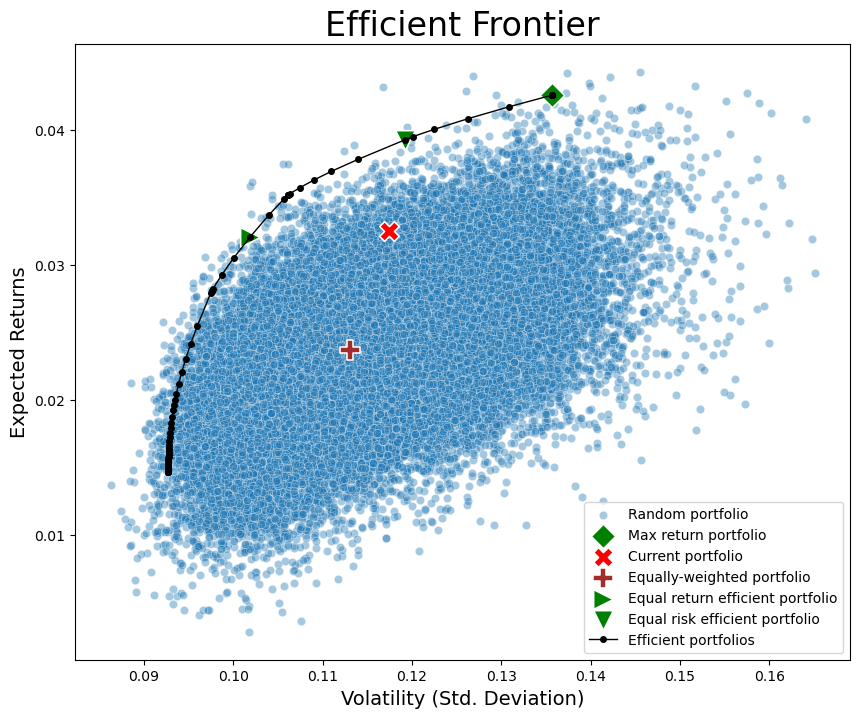

In [42]:
sns.scatterplot(data=random_portfolios, x='Volatility', y='Returns', alpha=0.4, label='Random portfolio')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

sns.scatterplot(x=[mr_volatility], y=[mr_return], marker='D', color='green', s=150, label='Max return portfolio')
sns.scatterplot(x=[current_volatility], y=[current_return], marker='X', color='red', s=200, label='Current portfolio')
sns.scatterplot(x=[equally_volatility], y=[equally_return], marker='P', color='brown', s=200, label='Equally-weighted portfolio')
sns.scatterplot(x=[equal_return_volatility], y=[equal_return_return], marker='>', color='green', s=200, label='Equal return efficient portfolio')
sns.scatterplot(x=[equal_risk_volatility], y=[equal_risk_return], marker='v', color='green', s=200, label='Equal risk efficient portfolio')

# Plot the set of portfolios on the EF
plt.plot(effective_frontier_risks, effective_frontier_returns, 'k-o', linewidth=1, ms=4, label='Efficient portfolios')
plt.legend()

plt.show()

### Print portfolios weights

Collect portfolios to one DataFrame.

In [44]:
max_return_portfolio = pd.DataFrame(max_return_weights[:,0], index=portfolio, columns=['Max return weights'])
equal_return_portfolio = pd.DataFrame(equal_return_weights[:,0], index=portfolio, columns=['Equal return weights'])
equal_risk_portfolio = pd.DataFrame(equal_risk_weights[:,0], index=portfolio, columns=['Equal risk weights'])

portfolios = pd.concat([max_return_portfolio, equal_return_portfolio, equal_risk_portfolio], axis=1)

portfolios

,Max return weights,Equal return weights,Equal risk weights
AAPL,0.153846,0.153846,0.153846
ABBV,0.153846,0.153846,0.153846
BAC,0.038462,0.038462,0.038462
BTI,0.038462,0.047391,0.038462
C,0.038462,0.038462,0.038462
CMCSA,0.038462,0.038462,0.038462
FDX,0.153846,0.047517,0.153846
GPS,0.153846,0.038462,0.073068
HPQ,0.076923,0.118433,0.153846
INTC,0.038462,0.038462,0.038462


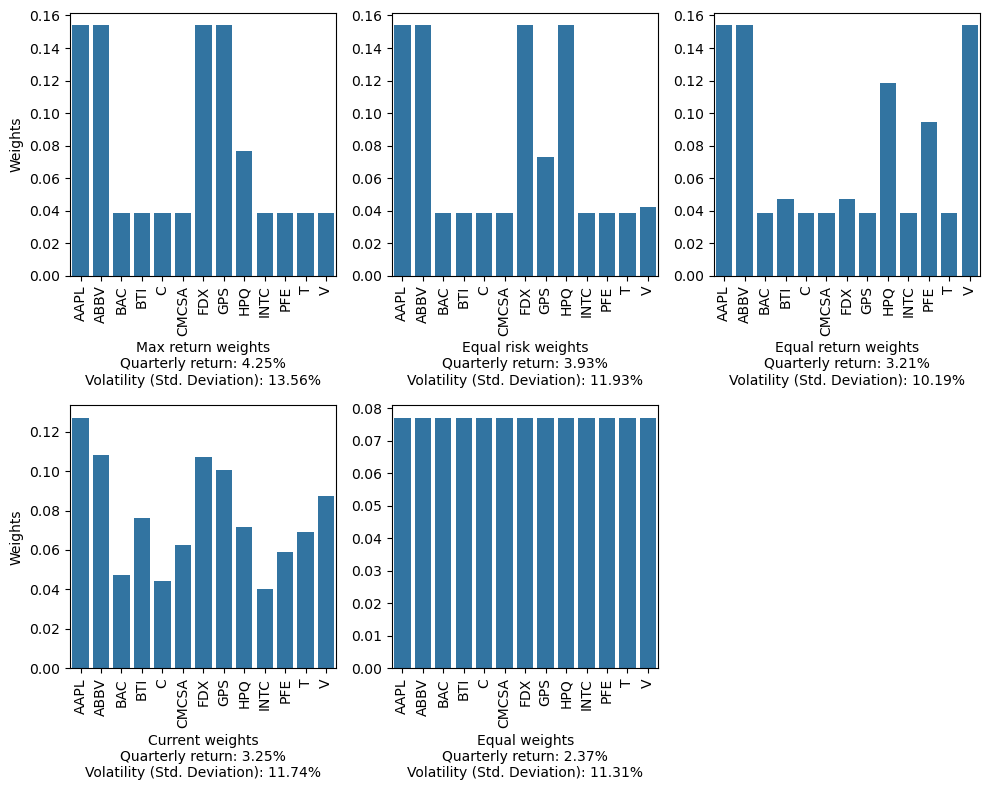

In [45]:
ax1 = plt.subplot(2,3,1)
sns.barplot(x=portfolios.index, y=portfolios['Max return weights'])
plt.ylabel("Weights");
plt.xlabel(f"Max return weights\nQuarterly return: {round(mr_return*100,2)}%\nVolatility (Std. Deviation): {round(mr_volatility*100,2)}%");
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.tight_layout()

ax2 = plt.subplot(2,3,2)
sns.barplot(x=portfolios.index, y=portfolios['Equal risk weights'])
plt.ylabel("");
plt.xlabel(f"Equal risk weights\nQuarterly return: {round(equal_risk_return*100,2)}%\nVolatility (Std. Deviation): {round(equal_risk_volatility*100,2)}%");
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
plt.tight_layout()

ax3 = plt.subplot(2,3,3)
sns.barplot(x=portfolios.index, y=portfolios['Equal return weights'])
plt.ylabel("");
plt.xlabel(f"Equal return weights\nQuarterly return: {round(equal_return_return*100,2)}%\nVolatility (Std. Deviation): {round(equal_return_volatility*100,2)}%");
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
plt.tight_layout()

ax4 = plt.subplot(2,3,4)
sns.barplot(x=portfolio, y=current_weights)
plt.ylabel("Weights");
plt.xlabel(f"Current weights\nQuarterly return: {round(current_return*100,2)}%\nVolatility (Std. Deviation): {round(current_volatility*100,2)}%");
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
plt.tight_layout()

ax5 = plt.subplot(2,3,5)
sns.barplot(x=portfolio, y=equally_weights[:,0])
plt.ylabel("");
plt.xlabel(f"Equal weights\nQuarterly return: {round(equally_return*100,2)}%\nVolatility (Std. Deviation): {round(equally_volatility*100,2)}%");
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()

As the result we have set of portfolios with different weights and their quarterly performance.